# Deep Learning Time Series COVID-19 Prediction

## Project Setup

### Libraries importing

In [1]:
# Auto reload imported module every time a jupyter cell is executed
%load_ext autoreload
%autoreload 2

In [60]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.express as px
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
import pandas_profiling
from typing import overload
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop 
from covid_time_series_prediction.ml_logic import preprocessor
# from ml_logic.country_data import country_output
from covid_time_series_prediction.ml_logic.preprocessor import train_test_set, scaler

### Raw data

In [3]:
# #### Data project directory
# data_dir = '../data/raw_data/'

# Vizualization

In [ ]:
# fig, ax = plt.subplots(1, figsize=(17,7))
# plt.plot(          ['new_deaths']);
# ax.set_title("Covid 19 calculation for different countries", size=10)
# ax.set_ylabel("Number of death cases", size=10)
# ax.set_xlabel("Date", size=13)

## Data loading

## TENSORFLOW & RNN MODEL

### Recurrent Neural Network (sequences data) modeling

### Samples/Sequences, Observations, Features

X.shape = (n_SEQUENCES, n_OBSERVATIONS, n_FEATURES) and y = RNN(X) where $X_{i,j}^{t}$

with $_{i}$ is the sample/sequence, $_{j}$ is the feature measured and  $^{t}$ is the time at which the observation is seen



### Prerequisites:

- **retrieve dataset** from Sumedha & Alberto

    - **clean dataset**: 
        
        - **drop first lines == 0** *(before Covid arrived)*
        
        - **check Nan**: 
- **strategy 1 country by country** sequences split as follow:

- **strategy 2 one sequence per country**:
    - **split X train, set** 
    - **Pad sequences**
    - **create one csv per country**

## Training strategies:
- Get NB dataset (cleaned) from Alberto & Sumedha
- 1/ Indicator in precentage %
- 2/ Indicator as categorical labels
- Run same RNN model in parallel with Kim & Thomas
- Identify best dataset
- Parameters to fit:
    - increase **nb of sequences**
    - train series modulation (ex: [50, 150, 200, 300, 400 nb of days = n_obs]) < take time to compute
    - **learning_rate** in Optimizer(parameters)
    - model layers architecture (**simple** -> complex) (less data -> more data) (print(loss) function check lecture)
        > LSTM
        > Dense
       (> LSTM
        > LSTM
        > Dense)
     >> **try to overfit** the model with the loss (train over val) or (early_stopping)
     >> **(X_val, y_val)**

### Feature Selection

# RNN model Starting

In [4]:
# Train set
n_seq = 200 ## nb of sequences (samples)
n_obs = 61 # maxi = 96 (stay around 70 or more test_split)
n_feat = 20 #  X_train.shape[1] # 20 feature:
n_pred = 1 # nb of days where we can predict new daily deaths
n_seq, n_obs, n_feat

(200, 61, 20)

### Train Splitting

Split the dataset into training, validation, and test datasplit the dataset into training, validation, and test data

In [5]:
# Train set
X_train, y_train, X_val, y_val, X_test, y_test = train_test_set('France', split_train=0.7, split_val=0.9)
np.ndim(X_train), np.ndim(y_train), np.ndim(X_val), np.ndim(y_val), np.ndim(X_test), np.ndim(y_test)

(2, 1, 2, 1, 2, 1)

#### Create sequences (`X`,`y`)

##### Generates an entire dataset of multiple subsamples with shape $(X, y)$

In [6]:
def subsample_sequence(X, y, X_len, y_len) -> pd.DataFrame:
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length` (eg n_obs).
    This shorter sequence should be selected at random
    """
    X_y_len = X_len + y_len
    print('_len + y_len',  X_len,  y_len)
    print('X.shape[0] >= X_y_len', X.shape[0], X_y_len)
    if X.shape[0] >= X_y_len:
        last_possible = X.shape[0] - X_y_len
    else:
        last_possible = X.shape[0]
        print('X_y_len = ?', X.shape[0])
    # How to split sequences? we could do it manually...
    print('X.shape[0]', X.shape[0])
    random_start = np.random.randint(0, last_possible)
    # X start and y end
    X_sample = X[random_start : random_start + X_len]
    y_sample = y[random_start + X_len : (random_start + X_y_len)]
    print("X[random_start : random_start + X_len]", f"X[{random_start} : {random_start + X_len}]")
    print("y[random_start : random_start + X_y_len]", f"y[{random_start} : {(random_start + X_y_len)}]")
    
    return np.array(X_sample), np.array(y_sample)

In [7]:
# Subsample sequence
(X_sample, y_sample) = subsample_sequence(X_train, y_train, X_len=n_obs, y_len=n_pred)
X_sample.shape, y_sample.shape

_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[548 : 609]
y[random_start : random_start + X_y_len] y[548 : 610]


((61, 20), (1,))

##### **get_X_y(df, n_sequences, length)**

function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

In [8]:
def get_X_y(X, y, X_len, y_len, n_sequences) -> tuple:
    '''Return a list of samples (X, y)'''
    X_list, y_list = [], []

    for i in range(n_sequences):
        (xi, yi) = subsample_sequence(X, y, X_len=X_len, y_len=y_len)
        X_list.append(xi)
        y_list.append(yi)
        
    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

In [9]:
n_seq_val = n_seq // 5 # number of sequences in test set ?
n_seq_test = n_seq // 10 # number of sequences in test set ?
n_seq, n_seq_val, n_seq_test

(200, 40, 20)

In [10]:
X_test.shape, y_test.shape

((97, 20), (97,))

In [11]:
X_test, y_test = get_X_y(X_test, y_test, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_test)
print('X_test.shape, y_test.shape, n_seq_test, n_obs, n_feat')
X_test.shape, y_test.shape, n_seq_test, n_obs, n_feat

_len + y_len 61 1
X.shape[0] >= X_y_len 97 62
X.shape[0] 97
X[random_start : random_start + X_len] X[23 : 84]
y[random_start : random_start + X_y_len] y[23 : 85]
_len + y_len 61 1
X.shape[0] >= X_y_len 97 62
X.shape[0] 97
X[random_start : random_start + X_len] X[7 : 68]
y[random_start : random_start + X_y_len] y[7 : 69]
_len + y_len 61 1
X.shape[0] >= X_y_len 97 62
X.shape[0] 97
X[random_start : random_start + X_len] X[9 : 70]
y[random_start : random_start + X_y_len] y[9 : 71]
_len + y_len 61 1
X.shape[0] >= X_y_len 97 62
X.shape[0] 97
X[random_start : random_start + X_len] X[25 : 86]
y[random_start : random_start + X_y_len] y[25 : 87]
_len + y_len 61 1
X.shape[0] >= X_y_len 97 62
X.shape[0] 97
X[random_start : random_start + X_len] X[34 : 95]
y[random_start : random_start + X_y_len] y[34 : 96]
_len + y_len 61 1
X.shape[0] >= X_y_len 97 62
X.shape[0] 97
X[random_start : random_start + X_len] X[1 : 62]
y[random_start : random_start + X_y_len] y[1 : 63]
_len + y_len 61 1
X.shape[0] >= X_

((20, 61, 20), (20, 1), 20, 61, 20)

In [12]:
X_val, y_val = get_X_y(X_val, y_val, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_val)
print('X_val.shape, y_val.shape, n_seq, n_seq_val, n_seq_test, n_obs, n_feat')
X_val.shape, y_val.shape, n_seq, n_seq_val, n_seq_test, n_obs, n_feat

_len + y_len 61 1
X.shape[0] >= X_y_len 192 62
X.shape[0] 192
X[random_start : random_start + X_len] X[121 : 182]
y[random_start : random_start + X_y_len] y[121 : 183]
_len + y_len 61 1
X.shape[0] >= X_y_len 192 62
X.shape[0] 192
X[random_start : random_start + X_len] X[116 : 177]
y[random_start : random_start + X_y_len] y[116 : 178]
_len + y_len 61 1
X.shape[0] >= X_y_len 192 62
X.shape[0] 192
X[random_start : random_start + X_len] X[123 : 184]
y[random_start : random_start + X_y_len] y[123 : 185]
_len + y_len 61 1
X.shape[0] >= X_y_len 192 62
X.shape[0] 192
X[random_start : random_start + X_len] X[57 : 118]
y[random_start : random_start + X_y_len] y[57 : 119]
_len + y_len 61 1
X.shape[0] >= X_y_len 192 62
X.shape[0] 192
X[random_start : random_start + X_len] X[93 : 154]
y[random_start : random_start + X_y_len] y[93 : 155]
_len + y_len 61 1
X.shape[0] >= X_y_len 192 62
X.shape[0] 192
X[random_start : random_start + X_len] X[59 : 120]
y[random_start : random_start + X_y_len] y[59 : 121

((40, 61, 20), (40, 1), 200, 40, 20, 61, 20)

X_train, y_train, X_val, y_val, X_test, y_test = train_test_set('United States', split_train=0.7, split_val=0.9)

X_train, y_train = get_X_y(X_train, y_train, X_test, y_test, X_len=n_obs, y_len=n_pred, n_seq_train=n_seq_test, X_val=X_val, y_val=y_val)
X_train.shape, y_train.shape, n_seq, n_seq_val, n_seq_test, n_obs, n_feat

In [13]:
X_train, y_train = get_X_y(X_train, y_train, X_len=n_obs, y_len=n_pred, n_sequences=n_seq)
X_train.shape, y_train.shape, n_seq, n_obs, n_feat

_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[409 : 470]
y[random_start : random_start + X_y_len] y[409 : 471]
_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[315 : 376]
y[random_start : random_start + X_y_len] y[315 : 377]
_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[115 : 176]
y[random_start : random_start + X_y_len] y[115 : 177]
_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[63 : 124]
y[random_start : random_start + X_y_len] y[63 : 125]
_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[253 : 314]
y[random_start : random_start + X_y_len] y[253 : 315]
_len + y_len 61 1
X.shape[0] >= X_y_len 672 62
X.shape[0] 672
X[random_start : random_start + X_len] X[55 : 116]
y[random_start : random_start + X_y_len] y[55 : 1

((200, 61, 20), (200, 1), 200, 61, 20)

X_val, y_val = get_X_y_2(X_val, y_val, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_val)
X_val.shape, y_val.shape, n_seq_val, n_obs, n_feat

In [14]:
# np.ndim(X_train), np.ndim(y_train), np.ndim(X_val), np.ndim(y_val), np.ndim(X_test), np.ndim(y_test)

In [15]:
# # Train set
# def train_rnn_model(model, patience=7, epochs=200):
#     es = EarlyStopping(monitor = 'val_loss',
#                     patience = patience,
#                     verbose = 1,
#                     restore_best_weights = True)
#     # Fit
#     history =  model.fit(X_train, y_train, 
#             validation_split=0.1, # Auto split for validation data
#             batch_size = 16,
#             epochs = epochs,
#             callbacks = [es],
#             verbose=1)
#     return history


##### How to split sequences?



- randomly or

- manually

##### **train_rnn_model(model, patience=2, epochs=200):**

function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

## RNN model Training

In [16]:
# 3. Training
def train_rnn_model(model, patience=7, epochs=200):
    """ function that train a RNN model with hyperparameters:
    - patience by default 7 to early stop
    - epochs by default 200 to train over several epochs
    - validation data by default (X_val, y_val)
    """
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  model.fit(X_train,
            y_train, 
             # Auto split for validation data
            validation_data=(X_val, y_val),
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history


In [17]:
X_val.shape

(40, 61, 20)

In [18]:
# Test
 
# Normalization layer
normalizer = Normalization()  # Instantiate a "normalizer" layer
normalizer.adapt(X_train) # "Fit" it on the train set

# 1. The Architecture
"""   - model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model = Sequential()
# Input len(train) (input_shape=(?,?))
rnn_model.add(LSTM(units=20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# output return sequences = True
rnn_model.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model.add(Dense(n_pred, activation = 'linear'))

# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model.summary()



2022-09-14 01:43:18.245205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-14 01:43:18.245438: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-14 01:43:18.245551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-S0MTM0QT): /proc/driver/nvidia/version does not exist
2022-09-14 01:43:18.246795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,501
Trainable params: 3,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 3. Evaluating
history = train_rnn_model(rnn_model, epochs=200, patience=3)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();



Epoch 1/200
13/13 [==============================] - 5s 156ms/step - loss: 6473532928.0000 - mape: 99.9936 - val_loss: 19251621888.0000 - val_mape: 99.9883
Epoch 2/200
13/13 [==============================] - 1s 95ms/step - loss: 32007528448.0000 - mape: 158.3742 - val_loss: 19229872128.0000 - val_mape: 99.9310
Epoch 3/200
13/13 [==============================] - 1s 72ms/step - loss: 6327138816.0000 - mape: 96.6764 - val_loss: 19227764736.0000 - val_mape: 99.9256
Epoch 4/200
13/13 [==============================] - 1s 87ms/step - loss: 6295217152.0000 - mape: 96.1397 - val_loss: 19225155584.0000 - val_mape: 99.9184
Epoch 5/200
13/13 [==============================] - 1s 95ms/step - loss: 6212145664.0000 - mape: 94.7810 - val_loss: 19229542400.0000 - val_mape: 99.9300
Epoch 6/200
13/13 [==============================] - 1s 99ms/step - loss: 5555578880.0000 - mape: 86.1647 - val_loss: 19201193984.0000 - val_mape: 99.8559
Epoch 7/200
13/13 [==============================] - 1s 80ms/step -

In [20]:
# 4. Prediction
y_pred = rnn_model.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

(20, 1)


0    99719.171875
dtype: float32

### RNN model 2 architecture 

In [21]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_2 = Sequential()
rnn_model_2.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_2.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_2.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_2.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_2.add(Dense(n_pred, activation = 'linear'))

## RNN model 2 training

In [22]:
# 3. Training
def train_rnn_model_2(rnn_model_2, patience=20, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  rnn_model_2.fit(X_train,
            y_train, 
            validation_split=0.1, # Auto split for validation data
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history


### Model 2 evaluating

In [23]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_2.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

(20, 1)


0    0.526006
dtype: float32

### Compile model 2 with 'rmsprop'

In [24]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_2.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 20)         41        
 n)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30)                6120      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,482
Trainable params: 6,441
Non-trainable params: 41
_________________________________________________________________


### Train model 2

In [25]:
history = train_rnn_model(model=rnn_model_2, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

Epoch 1/200
13/13 [==============================] - 8s 205ms/step - loss: 6473894400.0000 - mape: 99.9994 - val_loss: 19255900160.0000 - val_mape: 99.9995
Epoch 2/200
13/13 [==============================] - 1s 83ms/step - loss: 6473641984.0000 - mape: 99.9982 - val_loss: 19255980032.0000 - val_mape: 99.9996
Epoch 3/200
13/13 [==============================] - 1s 71ms/step - loss: 6473327104.0000 - mape: 99.9960 - val_loss: 19256070144.0000 - val_mape: 99.9999
Epoch 4/200
13/13 [==============================] - 1s 87ms/step - loss: 6473032192.0000 - mape: 99.9933 - val_loss: 19256272896.0000 - val_mape: 100.0004
Epoch 5/200
13/13 [==============================] - 1s 71ms/step - loss: 6472750080.0000 - mape: 99.9897 - val_loss: 19256297472.0000 - val_mape: 100.0005
Epoch 6/200
13/13 [==============================] - 1s 78ms/step - loss: 6472491520.0000 - mape: 99.9859 - val_loss: 19256303616.0000 - val_mape: 100.0005


keras.callbacks.History

In [26]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_2.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

(20, 1)


0    0.702928
dtype: float32

### RNN model 3, LSTM 

In [36]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model.add(Dense(20, activation = 'relu'))
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Compile model 3 with 'rmsprop'

In [37]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 20)         41        
 n)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 30)                6120      
                                                                 
 dense_9 (Dense)             (None, 10)                310       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 6,482
Trainable params: 6,441
Non-trainable params: 41
_________________________________________________________________


In [39]:
history = train_rnn_model(rnn_model_3, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

Epoch 1/200
12/12 [==============================] - 10s 254ms/step - loss: 6508276736.0000 - mape: 99.9994 - val_loss: 6164699648.0000 - val_mape: 99.9978
Epoch 2/200
12/12 [==============================] - 1s 74ms/step - loss: 6508140544.0000 - mape: 99.9984 - val_loss: 6164560896.0000 - val_mape: 99.9964
Epoch 3/200
12/12 [==============================] - 1s 81ms/step - loss: 6507987456.0000 - mape: 99.9972 - val_loss: 6164376576.0000 - val_mape: 99.9946
Epoch 4/200
12/12 [==============================] - 1s 71ms/step - loss: 6507793920.0000 - mape: 99.9955 - val_loss: 6164177920.0000 - val_mape: 99.9918
Epoch 5/200
12/12 [==============================] - 1s 71ms/step - loss: 6507608064.0000 - mape: 99.9936 - val_loss: 6164004864.0000 - val_mape: 99.9896
Epoch 6/200
12/12 [==============================] - 1s 83ms/step - loss: 6507442176.0000 - mape: 99.9918 - val_loss: 6163833344.0000 - val_mape: 99.9876
Epoch 7/200
12/12 [==============================] - 1s 71ms/step - loss: 

keras.callbacks.History

In [30]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_3.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

(20, 1)


0    0.335179
dtype: float32

### RNN model 4 architecture

In [31]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_4 = Sequential()
rnn_model_4.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_4.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_4.add(Dense(15, activation = 'relu'))
rnn_model_4.add(Dense(5, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_4.add(Dense(n_pred, activation = 'linear'))

### Compile model 4 with 'rmsprop'

In [32]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_4.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 20)         41        
 n)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 30)                6120      
                                                                 
 dense_6 (Dense)             (None, 10)                310       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,482
Trainable params: 6,441
Non-trainable params: 41
_________________________________________________________________


### Training model 4

In [33]:
# 3. Training
from typing import overload

def train_rnn_model(rnn_model_4, patience=2, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  rnn_model_4.fit(X_train, y_train, 
            validation_split=0.1, # Auto split for validation data
                ## validation_data = (X_val, y_val), # To be created manually if needed
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history



In [35]:
history = train_rnn_model(rnn_model_4, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

Epoch 1/200
12/12 [==============================] - 10s 198ms/step - loss: 6508309504.0000 - mape: 99.9989 - val_loss: 6164724224.0000 - val_mape: 99.9962
Epoch 2/200
12/12 [==============================] - 1s 77ms/step - loss: 6508161536.0000 - mape: 99.9980 - val_loss: 6164567040.0000 - val_mape: 99.9949
Epoch 3/200
12/12 [==============================] - 1s 74ms/step - loss: 6507995136.0000 - mape: 99.9966 - val_loss: 6164374016.0000 - val_mape: 99.9926
Epoch 4/200
12/12 [==============================] - 1s 77ms/step - loss: 6507831296.0000 - mape: 99.9950 - val_loss: 6164200448.0000 - val_mape: 99.9903
Epoch 5/200
12/12 [==============================] - 1s 79ms/step - loss: 6507670016.0000 - mape: 99.9935 - val_loss: 6164045312.0000 - val_mape: 99.9883
Epoch 6/200
12/12 [==============================] - 1s 79ms/step - loss: 6507507712.0000 - mape: 99.9921 - val_loss: 6163877888.0000 - val_mape: 99.9865
Epoch 7/200
12/12 [==============================] - 1s 78ms/step - loss: 

keras.callbacks.History

In [50]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_4.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

(20, 1)


0    2.297131
dtype: float32

### Train model 5, LSTM X 2 layers

In [40]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(200, 61, 20)

In [45]:
# 1. The Architecture
"""   - 4th model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> GRU
"""
rnn_model_5 = Sequential()
rnn_model_5.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_5.add(LSTM(units=30, activation='tanh', return_sequences=True, input_shape=(None, X_train.shape[1], X_train.shape[2])))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_5.add(LSTM(units=20, activation='tanh', return_sequences =True))
rnn_model_5.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_5.add(Dense(n_pred, activation = 'linear'))

In [46]:
# 3. Training
from typing import overload

def train_rnn_model(rnn_model_5, patience=2, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  rnn_model_5.fit(X_train, y_train, 
            validation_split=0.1, # Auto split for validation data
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history

In [47]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_5.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 20)         41        
 n)                                                              
                                                                 
 lstm_11 (LSTM)              (None, None, 30)          6120      
                                                                 
 lstm_12 (LSTM)              (None, None, 20)          4080      
                                                                 
 dense_13 (Dense)            (None, None, 10)          210       
                                                                 
 dense_14 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 10,462
Trainable params: 10,421
Non-trainable params: 41
_________________________________________________

In [48]:
history = train_rnn_model(rnn_model_5, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

Epoch 1/200
12/12 [==============================] - 16s 447ms/step - loss: 6508325376.0000 - mape: 99.9999 - val_loss: 6164756992.0000 - val_mape: 99.9999
Epoch 2/200
12/12 [==============================] - 2s 148ms/step - loss: 6508195840.0000 - mape: 99.9990 - val_loss: 6164599296.0000 - val_mape: 99.9983
Epoch 3/200
12/12 [==============================] - 2s 131ms/step - loss: 6508064256.0000 - mape: 99.9978 - val_loss: 6164476928.0000 - val_mape: 99.9967
Epoch 4/200
12/12 [==============================] - 2s 130ms/step - loss: 6507945984.0000 - mape: 99.9967 - val_loss: 6164366848.0000 - val_mape: 99.9952
Epoch 5/200
12/12 [==============================] - 2s 168ms/step - loss: 6507844096.0000 - mape: 99.9956 - val_loss: 6164276224.0000 - val_mape: 99.9940
Epoch 6/200
12/12 [==============================] - 2s 158ms/step - loss: 6507753984.0000 - mape: 99.9947 - val_loss: 6164186112.0000 - val_mape: 99.9928
Epoch 7/200
12/12 [==============================] - 2s 154ms/step - 

keras.callbacks.History

In [90]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_5.predict(X_test) 
print(y_pred)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

[[[248.95366]
  [511.51523]
  [547.71704]
  ...
  [553.5758 ]
  [553.5758 ]
  [553.5758 ]]

 [[248.95366]
  [511.51523]
  [547.71704]
  ...
  [553.5758 ]
  [553.5758 ]
  [553.5758 ]]

 [[248.95366]
  [511.51523]
  [547.71704]
  ...
  [553.5758 ]
  [553.5758 ]
  [553.5758 ]]

 ...

 [[248.95366]
  [511.51523]
  [547.71704]
  ...
  [553.5758 ]
  [553.5758 ]
  [553.5758 ]]

 [[248.95366]
  [511.51523]
  [547.7171 ]
  ...
  [553.5758 ]
  [553.5758 ]
  [553.5758 ]]

 [[248.95366]
  [511.51523]
  [547.7171 ]
  ...
  [553.5758 ]
  [553.5758 ]
  [553.5758 ]]]


ValueError: Must pass 2-d input. shape=(20, 61, 1)

### Train model 6, GRU layer

In [61]:
# 1. The Architecture
"""   - 6th model layers architecture
> GRU
"""
rnn_model_6 = Sequential()
rnn_model_6.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_6.add(GRU(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_6.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_6.add(Dense(n_pred, activation = 'linear'))

In [62]:
# 3. Training
from typing import overload

def train_rnn_model(rnn_model_6, patience=2, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  rnn_model_6.fit(X_train, y_train, 
            validation_split=0.1, # Auto split for validation data
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history

In [63]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_6.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_6.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 20)         41        
 n)                                                              
                                                                 
 gru_4 (GRU)                 (None, 30)                4680      
                                                                 
 dense_17 (Dense)            (None, 10)                310       
                                                                 
 dense_18 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,042
Trainable params: 5,001
Non-trainable params: 41
_________________________________________________________________


Epoch 1/200
12/12 [==============================] - 5s 129ms/step - loss: 6508211712.0000 - mape: 99.9973 - val_loss: 6164634624.0000 - val_mape: 99.9925
Epoch 2/200
12/12 [==============================] - 1s 79ms/step - loss: 6508042240.0000 - mape: 99.9963 - val_loss: 6164467200.0000 - val_mape: 99.9919
Epoch 3/200
12/12 [==============================] - 1s 87ms/step - loss: 6507843584.0000 - mape: 99.9952 - val_loss: 6164217856.0000 - val_mape: 99.9901
Epoch 4/200
12/12 [==============================] - 1s 75ms/step - loss: 6507555328.0000 - mape: 99.9932 - val_loss: 6163867648.0000 - val_mape: 99.9878
Epoch 5/200
12/12 [==============================] - 1s 92ms/step - loss: 6507193856.0000 - mape: 99.9904 - val_loss: 6163424256.0000 - val_mape: 99.9827
Epoch 6/200
12/12 [==============================] - 1s 118ms/step - loss: 6506816000.0000 - mape: 99.9868 - val_loss: 6163078144.0000 - val_mape: 99.9791
Epoch 7/200
12/12 [==============================] - 1s 120ms/step - loss:

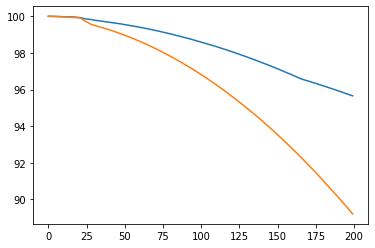

keras.callbacks.History

In [64]:
history = train_rnn_model(rnn_model_6, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

In [65]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_6.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

(20, 1)


0    718.29187
dtype: float32

### Train model 7, GRU X 2 layers

In [84]:
# 1. The Architecture
"""   - 7th model layers architecture
> GRU X 2
"""
rnn_model_7 = Sequential()
rnn_model_7.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_7.add(GRU(units=30, activation='tanh', return_sequences=True, input_shape=(None, X_train.shape[1], X_train.shape[2])))  ## , input_shape=(?,?))) without a Normalizer layer
rnn_model_7.add(GRU(units=20, activation='tanh', return_sequences=True))
rnn_model_7.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_7.add(Dense(n_pred, activation = 'linear'))

In [85]:
# 3. Training
from typing import overload

def train_rnn_model(rnn_model_7, patience=2, epochs=200):
    es = EarlyStopping(monitor = 'val_loss',
                    patience = patience,
                    verbose = 0,
                    restore_best_weights = True)
    # The fit
    history =  rnn_model_7.fit(X_train, y_train, 
            validation_split=0.1, # Auto split for validation data
            batch_size = 16,
            epochs = epochs,
            callbacks = [es],
            verbose=1)
    return history

In [86]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_7.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_7.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 20)         41        
 n)                                                              
                                                                 
 gru_6 (GRU)                 (None, None, 30)          4680      
                                                                 
 gru_7 (GRU)                 (None, None, 20)          3120      
                                                                 
 dense_19 (Dense)            (None, None, 10)          210       
                                                                 
 dense_20 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 8,062
Trainable params: 8,021
Non-trainable params: 41
__________________________________________________

Epoch 1/200
12/12 [==============================] - 6s 192ms/step - loss: 6508340736.0000 - mape: 99.9999 - val_loss: 6164800000.0000 - val_mape: 100.0000
Epoch 2/200
12/12 [==============================] - 2s 128ms/step - loss: 6508286464.0000 - mape: 99.9993 - val_loss: 6164745728.0000 - val_mape: 99.9988
Epoch 3/200
12/12 [==============================] - 1s 123ms/step - loss: 6508220928.0000 - mape: 99.9987 - val_loss: 6164642816.0000 - val_mape: 99.9978
Epoch 4/200
12/12 [==============================] - 1s 120ms/step - loss: 6508121600.0000 - mape: 99.9980 - val_loss: 6164547072.0000 - val_mape: 99.9965
Epoch 5/200
12/12 [==============================] - 2s 126ms/step - loss: 6508022784.0000 - mape: 99.9972 - val_loss: 6164463616.0000 - val_mape: 99.9954
Epoch 6/200
12/12 [==============================] - 1s 125ms/step - loss: 6507936768.0000 - mape: 99.9965 - val_loss: 6164393984.0000 - val_mape: 99.9944
Epoch 7/200
12/12 [==============================] - 1s 120ms/step - 

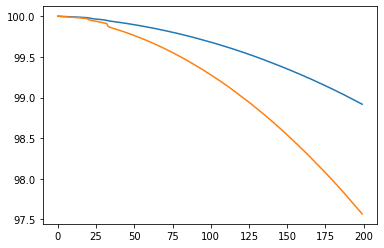

keras.callbacks.History

In [87]:
history = train_rnn_model(rnn_model_7, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

In [89]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model_7.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

[[[166.99881]
  [359.90118]
  [420.147  ]
  ...
  [423.9484 ]
  [423.94827]
  [423.94815]]

 [[166.51483]
  [359.48444]
  [420.10287]
  ...
  [423.94675]
  [423.94656]
  [423.9465 ]]

 [[166.45361]
  [359.4035 ]
  [420.09558]
  ...
  [423.94693]
  [423.94684]
  [423.9467 ]]

 ...

 [[166.50644]
  [359.47742]
  [420.10526]
  ...
  [423.94702]
  [423.9469 ]
  [423.9468 ]]

 [[166.41922]
  [359.4327 ]
  [420.09976]
  ...
  [423.94656]
  [423.9465 ]
  [423.94638]]

 [[166.41922]
  [359.4327 ]
  [420.09976]
  ...
  [423.94656]
  [423.9465 ]
  [423.94638]]]


ValueError: Must pass 2-d input. shape=(20, 61, 1)